# Modelo Preditivo de Inflação - AM

## Instalação e Importe de Pacotes

In [ ]:
#!pip install python-bcb

In [ ]:
#!pip install pmdarima

In [1]:
import sys
sys.path.insert(0, '..')
from datetime import datetime
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from bcb import sgs
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima.arima import auto_arima
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn import linear_model
from statsmodels.tsa.vector_ar.vecm import VECM, select_order
from statsmodels.tsa.vector_ar.vecm import *
import plotly.express as px
from pandas.io.formats import style
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tools.eval_measures import rmse, aic
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tsa.stattools import acf
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
%matplotlib notebook

In [21]:
import statsmodels.api as sm

## Coleta dos Dados

Vamos importar nosso dataset inteiro com o pacote `bcb`, que utiliza a API do BCB para coletar dados de diversas séries temporais.

In [4]:
df = sgs.get({'IPCA': 433, 'sinapi': 7495, 'Selic': 4390, 'PIB': 4380, 'EnergiaElet': 1406, 'ProdAço': 28546, 'BM': 27840, 'Cambio': 3697, 'BalComerc': 22704, 'DivSetPub': 2053}, start='2007-01-01', end='2021-12-01')
df

,IPCA,sinapi,Selic,PIB,EnergiaElet,ProdAço,BM,Cambio,BalComerc,DivSetPub
Date,,,,,,,,,,
2007-01-01,0.44,0.27,1.08,206665.4,30700,136.42,105942665,2.1377,1656.7,735219.20
2007-02-01,0.44,0.41,0.87,201550.6,30325,138.86,105826866,2.0955,1962.9,743454.49
2007-03-01,0.37,0.62,1.05,223206.9,31313,140.10,108932806,2.0879,2184.8,756150.64
2007-04-01,0.25,0.41,0.94,218922.4,32031,140.61,118236384,2.0312,3283.8,753917.32
2007-05-01,0.28,0.90,1.03,227533.9,31383,143.84,112495027,1.9808,2571.7,772360.73
...,...,...,...,...,...,...,...,...,...,...
2021-08-01,0.87,0.99,0.43,739692.2,40629,154.51,412492332,5.2511,4098.0,3995521.56
2021-09-01,1.16,0.88,0.44,731334.1,41985,156.06,408457496,5.2791,1199.4,3969446.78
2021-10-01,1.25,1.01,0.49,739982.7,42622,142.84,395080369,5.5394,-76.4,3938553.03


Com o comando 'shape' podemos ver a dimensão de nosso dataset, onde 'n' representa o nº de observações e 'p' o nº de variáveis.

In [5]:
df.shape

(180, 10)

Ou seja, nossa base tem 180 observações e 10 variáveis.

## Tratamento dos Dados

Vamos trabalhar com 3 tipos de modelos preditivos, tendo cada um deles suas singularidades, e demandando consequentemente um tratamento especifíco da base de dados. Assim, vamos dividi-lá em 3 sub datasets, mas antes de tudo, vamos verificar as estatísticas descritivas de nossas séries.

In [6]:
df.describe()

,IPCA,sinapi,Selic,PIB,EnergiaElet,ProdAço,BM,Cambio,BalComerc,DivSetPub
count,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,1.800000e+02,180.000000,180.000000,1.800000e+02
mean,0.474000,0.550000,0.743556,459664.367778,37244.133333,140.124833,2.321229e+08,2.922323,-369.301667,1.694939e+06
std,0.318189,0.957413,0.267134,145395.284328,3285.633618,13.705745,8.091207e+07,1.208718,2678.339417,9.906307e+05
min,-0.380000,-6.150000,0.130000,201550.600000,30325.000000,83.110000,1.058269e+08,1.563100,-7775.500000,7.047954e+05
25%,0.257500,0.270000,0.540000,332367.550000,35150.250000,137.522500,1.777091e+08,1.875050,-1727.725000,9.845523e+05
50%,0.440000,0.440000,0.795000,478461.100000,38020.000000,142.875000,2.283642e+08,2.363250,-247.150000,1.130169e+06
75%,0.647500,0.692500,0.942500,569922.625000,39595.250000,147.520000,2.728431e+08,3.773400,1380.300000,2.555428e+06
max,1.350000,7.800000,1.220000,759981.100000,43416.000000,160.280000,4.348812e+08,5.650600,7567.900000,4.029713e+06


### 1º Sub dataset

In [7]:
df1 = df['IPCA']
df1 = pd.DataFrame(df1)
df1['Date'] = df1.index
df1

,IPCA,Date
Date,,
2007-01-01,0.44,2007-01-01
2007-02-01,0.44,2007-02-01
2007-03-01,0.37,2007-03-01
2007-04-01,0.25,2007-04-01
2007-05-01,0.28,2007-05-01
...,...,...
2021-08-01,0.87,2021-08-01
2021-09-01,1.16,2021-09-01
2021-10-01,1.25,2021-10-01


Com esta sub base vamos utilizar os modelos univariados auto-regressivos e de médias móveis (AR, MA, ARMA e ARIMA), por isso apenas utilizaremos a nossa série do IPCA. Ainda, para realizar a previsão com o modelo ARIMA precisamos dividi-lá em bases de treinamento (train) e de teste (test).

In [8]:
train = df1[df1['Date'] <= '2020-09-01']
train = train.rename(columns={'IPCA':"train"})
del train['Date']
test = df1[df1['Date'] >= '2020-09-01']
test = test.rename(columns={'IPCA':"test"})
del test['Date']

### 2º Sub dataset

Para os modelos multivariados, vamos trabalhar com a série do IPCA e as séries da taxa Selic e da taxa de Câmbio, que serão nossos regressores:

In [9]:
df2 = df.loc[:,['IPCA', 'Selic', 'Cambio']]
df2

,IPCA,Selic,Cambio
Date,,,
2007-01-01,0.44,1.08,2.1377
2007-02-01,0.44,0.87,2.0955
2007-03-01,0.37,1.05,2.0879
2007-04-01,0.25,0.94,2.0312
2007-05-01,0.28,1.03,1.9808
...,...,...,...
2021-08-01,0.87,0.43,5.2511
2021-09-01,1.16,0.44,5.2791
2021-10-01,1.25,0.49,5.5394


Ainda, vamos separar um dataset auxiliar com a 1ª diferença destas séries, caso elas não sejam estacionárias.

In [10]:
df_1ªdifference = df2.diff().dropna()

### 3º Sub dataset

Por último, montaremos um modelo que faz uso de técnicas avançadas de deep learning, então precisaremos converter nosso DataFrame principal em array:

In [11]:
df3 = df.values

E também vamos precisar separar nossa base em grupos de tratamento e de teste:

In [12]:
n = df.shape[0]
p = df.shape[1]

In [13]:
train_start = 0
train_end = int(np.floor(0.8*n))
test_start = train_end + 1
test_end = n

In [14]:
df_train = df3[np.arange(train_start, train_end), :]
df_test = df3[np.arange(test_start, test_end), :]

## Visualização dos Dados

Vamos plotar nossa série do IPCA num gráfico para ter uma identificação visual de como ela se comporta.

<IPython.core.display.Javascript object>


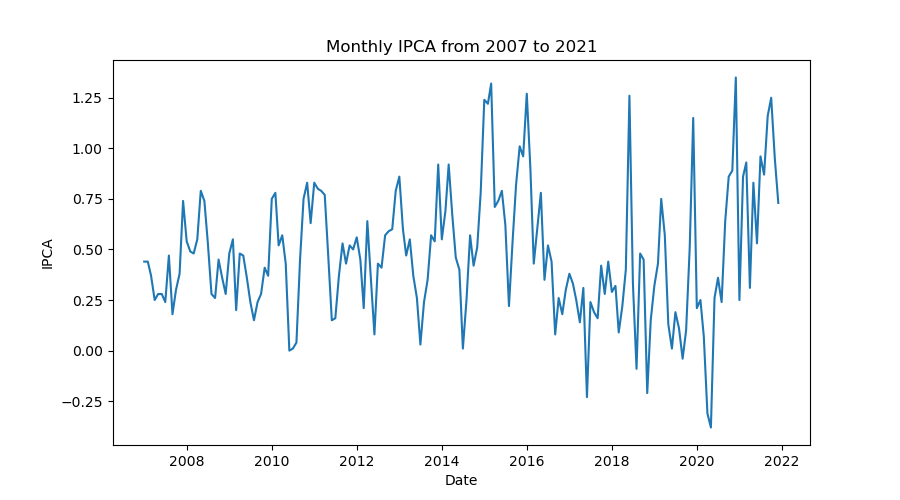

In [16]:
plt.figure(figsize=(9,5))
plt.plot(df.index, df['IPCA'], color='tab:blue')
plt.gca().set(title='Monthly IPCA from 2007 to 2021', xlabel='Date', ylabel='IPCA')
plt.show()

Estatísticas ricas em informações sobre nossa série são a média móvel e o desvio padrão móvel, que captam a dinâmica da média e da variação da série ao longo do tempo.

In [17]:
rolling_mean = df['IPCA'].rolling(3).mean()
rolling_std = df['IPCA'].rolling(3).std()

Podemos plota-lás em um gráfico, junto a nossa série do IPCA:

<IPython.core.display.Javascript object>


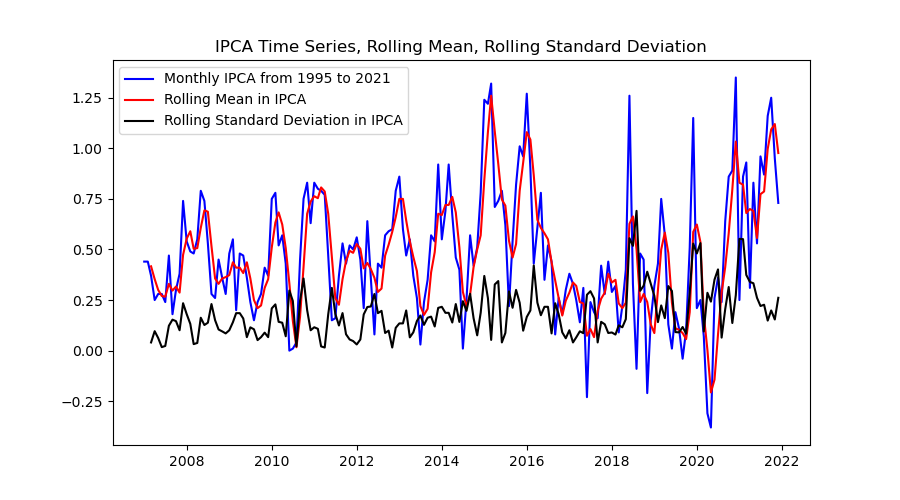

In [18]:
plt.figure(figsize=(9,5))
plt.plot(df['IPCA'], color="blue",label="Monthly IPCA from 1995 to 2021")
plt.plot(rolling_mean, color="red", label="Rolling Mean in IPCA")
plt.plot(rolling_std, color="black", label = "Rolling Standard Deviation in IPCA")
plt.title("IPCA Time Series, Rolling Mean, Rolling Standard Deviation")
plt.legend(loc="best")

Outro ponto importante sobre uma série temporal diz respeito a sua decomposição.
Uma série de tempo pode ser dividida em 4 componentes:

    * Componente estacionário;
    * Tendência;
    * Sazonalidade;
    * Ruído.
    
Vamos plotar 4 gráficos representando a decomposição de nossa série do IPCA.

<IPython.core.display.Javascript object>


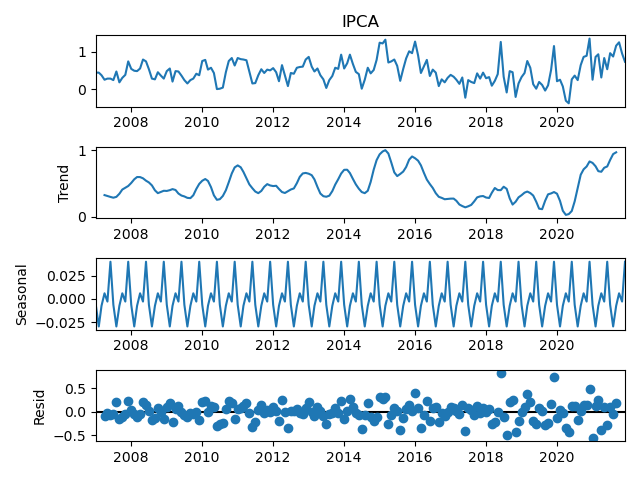

In [19]:
decompose = seasonal_decompose(df['IPCA'],model='additive', period=6)
decompose.plot()
plt.show()

Note o componente sazonal da inflação brasileira em passagens de um ano para o outro.

## Modelagem

### Estacionariedade

Como 1º passo para estimação dos modelos preditivos, vamos verificar se nossas séries são estacionárias.
Para isso, vamos construir uma função para realizar o teste de Dickey-Fuller aumentado para estacionariedade.

In [20]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Função que executa o Teste Dickey-Fuller Aumentado para verificar a estacionaridade de determinada série e
    retorna um relatório"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Teste Dickey-Fuller aumentado em "{name}"', "\n   ", '-'*47)
    print(f' Hipótese Nula: A série têm raiz unitária. Não é Estacionária.')
    print(f' Nível de significância    = {signif}')
    print(f' Estatística de teste        = {output["test_statistic"]}')
    print(f' Nº de lags escolhidos       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Valor crítico {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Valor = {p_value}. Rejeitando a Hipótese Nula.")
        print(f" => A série é estacionária.")
    else:
        print(f" => P-Valor = {p_value}. Evidência fraca para rejeitar a hipótese nula.")
        print(f" => A série é não estacionária.") 

Verificando então a estacionariedade das nossas séries do IPCA, da Selic e do Câmbio, que são das quais precisaremos para os modelos univariados e multivariados.

In [18]:
for name, column in df2.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Teste Dickey-Fuller aumentado em "IPCA" 
    -----------------------------------------------
 Hipótese Nula: A série têm raiz unitária. Não é Estacionária.
 Nível de significância    = 0.05
 Estatística de teste        = -4.8289
 Nº de lags escolhidos       = 12
 Valor crítico 1%     = -3.452
 Valor crítico 5%     = -2.871
 Valor crítico 10%    = -2.572
 => P-Valor = 0.0. Rejeitando a Hipótese Nula.
 => A série é estacionária.


    Teste Dickey-Fuller aumentado em "Selic" 
    -----------------------------------------------
 Hipótese Nula: A série têm raiz unitária. Não é Estacionária.
 Nível de significância    = 0.05
 Estatística de teste        = -2.7923
 Nº de lags escolhidos       = 13
 Valor crítico 1%     = -3.452
 Valor crítico 5%     = -2.871
 Valor crítico 10%    = -2.572
 => P-Valor = 0.0594. Evidência fraca para rejeitar a hipótese nula.
 => A série é não estacionária.


    Teste Dickey-Fuller aumentado em "Cambio" 
    -----------------------------------------------


Como podemos ver acima, apenas a série do IPCA apresentou estacionáriedade em nível. Para corrigir este problema, podemos recorrer a 1ª diferença das respectivas séries. Vamos então utilizar o dataset auxiliar 'df_1ªdifference' para isso:

In [19]:
for name, column in df_1ªdifference.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Teste Dickey-Fuller aumentado em "IPCA" 
    -----------------------------------------------
 Hipótese Nula: A série têm raiz unitária. Não é Estacionária.
 Nível de significância    = 0.05
 Estatística de teste        = -6.9209
 Nº de lags escolhidos       = 11
 Valor crítico 1%     = -3.452
 Valor crítico 5%     = -2.871
 Valor crítico 10%    = -2.572
 => P-Valor = 0.0. Rejeitando a Hipótese Nula.
 => A série é estacionária.


    Teste Dickey-Fuller aumentado em "Selic" 
    -----------------------------------------------
 Hipótese Nula: A série têm raiz unitária. Não é Estacionária.
 Nível de significância    = 0.05
 Estatística de teste        = -4.9045
 Nº de lags escolhidos       = 15
 Valor crítico 1%     = -3.452
 Valor crítico 5%     = -2.871
 Valor crítico 10%    = -2.572
 => P-Valor = 0.0. Rejeitando a Hipótese Nula.
 => A série é estacionária.


    Teste Dickey-Fuller aumentado em "Cambio" 
    -----------------------------------------------
 Hipótese Nula: A série tê

Tirando a 1ª diferença das séries da Selic e do Câmbio as tornamos estacionárias, possibilindo então utilizar o modelo multivariado VAR.

### Autocorrelação

Outra informação importante sobre nossa série de interesse diz respeito a seu grau de autocorrelação, dado que a maior parte dos modelos de séries temporais utilizam os valores passados das séries para explicar seus valores futuros.
Para verificar isto, vamos utlizar a função de autocorrelação:

In [20]:
autocorrelation_lag1 = df1['IPCA'].autocorr(lag=1)
print("Lag de 1 mês: ", autocorrelation_lag1)
autocorrelation_lag3 = df1['IPCA'].autocorr(lag=3)
print("Lag de 3 meses: ", autocorrelation_lag3)
autocorrelation_lag6 = df1['IPCA'].autocorr(lag=6)
print("Lag de 6 meses: ", autocorrelation_lag6)
autocorrelation_lag9 = df1['IPCA'].autocorr(lag=9)
print("Lag de 9 meses: ", autocorrelation_lag9)

Lag de 1 mês:  0.7047616130155863
Lag de 3 meses:  0.4138262119932968
Lag de 6 meses:  0.18664452585865252
Lag de 9 meses:  0.24544179619871975


Dos resultados acima podemos ver que a maior autocorrelação entre as observações de nossa série do IPCA se dá com lag de 1 mês.

## Previsão/Estimação utilizando modelos univariados

Começaremos nossa estimação com os modelos univariados, que consideram apenas os movimentos passados da série de interesse para estimar seus valores futuros.

### MA

Em modelos de médias móveis, temos um fator fixo, que é a média da série, e adicionalmente temos um componente residual variante com o tempo.

In [21]:
model = ARIMA(df1['IPCA'], order=(0, 0, 1), freq='MS')
model_fit = model.fit()
yhat1 = model_fit.predict(len(df1['IPCA']), len(df1['IPCA']))
print(yhat1)

C:\Users\Gustavo\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


2022-01-01    0.589024
Freq: MS, dtype: float64


Pela estimação de médias móveis, nosso y estimado pode ser visto acima, assumindo um valor de 0,589024.

### AR

Os processos Autorregressivos consideram única e exclusivamente os valores passados da série como regressores dos valores presente e futuro.

In [22]:
model = AutoReg(df1['IPCA'], lags=1)
model_fit = model.fit()
yhat2 = model_fit.predict(len(df1['IPCA']), len(df1['IPCA']))
print(yhat2)

C:\Users\Gustavo\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Gustavo\anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


2022-01-01    0.674544
Freq: MS, dtype: float64


C:\Users\Gustavo\anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


Acima temos o valor médio estimado do IPCA com base nos valores passados em um modelo AR de ordem 1.

### ARMA

Já o modelo ARMA, intuitivamente, considera tanto os valores passados da série quanto suas médias móveis, sendo uma junção dos dois modelos vistos acima.

In [23]:
model = ARIMA(df1['IPCA'], order=(2, 0, 1), freq='MS')
model_fit = model.fit()
yhat3 = model_fit.predict(len(df1['IPCA']), len(df1['IPCA']))
print(yhat3)

C:\Users\Gustavo\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Gustavo\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Gustavo\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


2022-01-01    0.673144
Freq: MS, dtype: float64


### ARIMA

Para finalizar o grupo de modelos univariados, temos o modelo ARIMA, que considera aquelas séries que são integradas, ou seja, com tendência estocástica, e que possuem erros estacionários.

In [24]:
model = ARIMA(df1['IPCA'], order=(1, 1, 1))
model_fit = model.fit()
yhat4 = model_fit.predict(len(df1['IPCA']), len(df1['IPCA']), typ='levels')
print(yhat4)

C:\Users\Gustavo\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Gustavo\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Gustavo\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


2022-01-01    0.722287
Freq: MS, dtype: float64


Novamente, acima temos o valor estimado de nossa variável de interesse.

Vamos agora tentar prever o IPCA utilizando o modelo ARIMA.

In [25]:
model = auto_arima(train, seasonal=True, trace=True, error_action='ignore', suppress_warnings=True)
model.fit(train)
forecast = model.predict(n_periods=len(test))
forecast = pd.DataFrame(forecast,index = test.index,columns=['Prediction'])

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=190.095, Time=0.84 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=232.283, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=229.881, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=225.349, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=230.313, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=188.778, Time=0.49 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=194.598, Time=0.56 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=190.925, Time=0.37 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=192.884, Time=0.52 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=190.960, Time=0.41 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=190.012, Time=0.41 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=192.518, Time=0.80 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=187.733, Time=0.18 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=193.197, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=189.9

No gráfico abaixo temos os grupos de treinamento (azul), de teste (vermelho) e a previsão (verde).

<IPython.core.display.Javascript object>


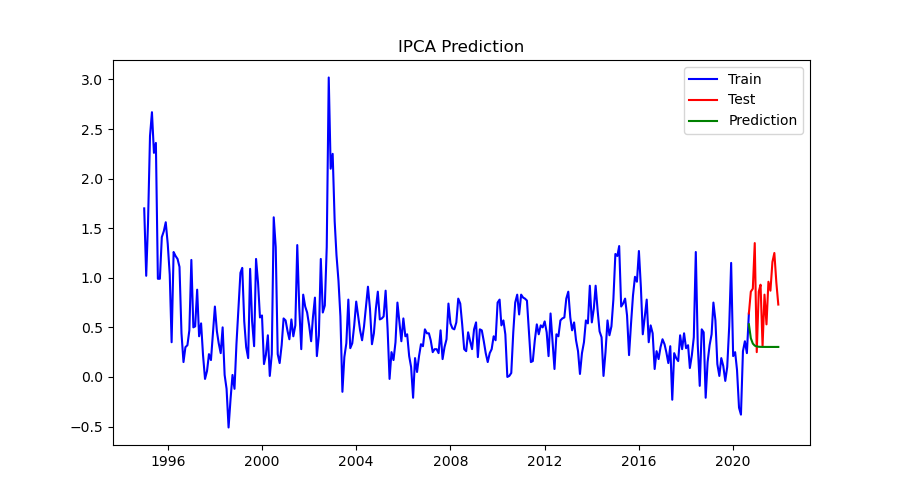

In [26]:
plt.figure(figsize=(9,5))
plt.plot(train, color="blue",label="Train")
plt.plot(test, color="red", label="Test")
plt.plot(forecast, color="green", label = "Prediction")
plt.title("IPCA Prediction")
plt.legend(loc="best")

C:\Users\Gustavo\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Gustavo\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


<IPython.core.display.Javascript object>


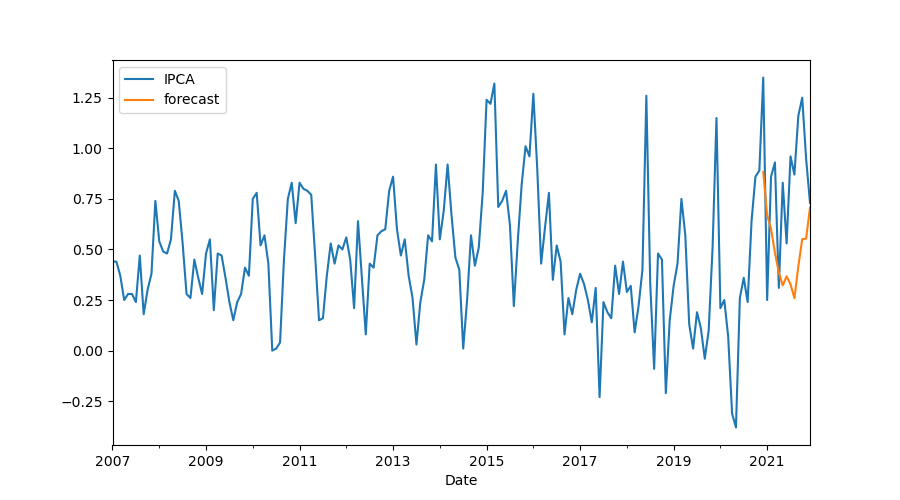

<AxesSubplot:xlabel='Date'>

In [24]:
model=sm.tsa.statespace.SARIMAX(df1['IPCA'],order=(1, 1, 1),seasonal_order=(1,1,1,12))
results=model.fit()
df1['forecast']=results.predict(start=167,end=180,dynamic=True)
df1[['IPCA','forecast']].plot(figsize=(9,5))

Como se pode ver, modelos univariados tem pouca acurácia para prever a inflação no Brasil medida pelo IPCA. Outra prova disso é o alto valor do erro quadrado médio neste modelo:

In [27]:
rms = sqrt(mean_squared_error(test,forecast))
print("RMSE: ", rms)

RMSE:  0.5933474622796933


## Previsão/Estimação utilizando modelos multivariados

Começaremos com o modelo VAR (Vector AutoRegressive), que abre espaço para a possibilidade de outras séries influenciarem nossa variável de interesse, mas que não podem ser não-estacionárias. Trabalharemos com 3 séries aqui, o IPCA, a Taxa Selic e a Taxa de Câmbio. Abaixo segue uma pré-visualização delas:

<IPython.core.display.Javascript object>


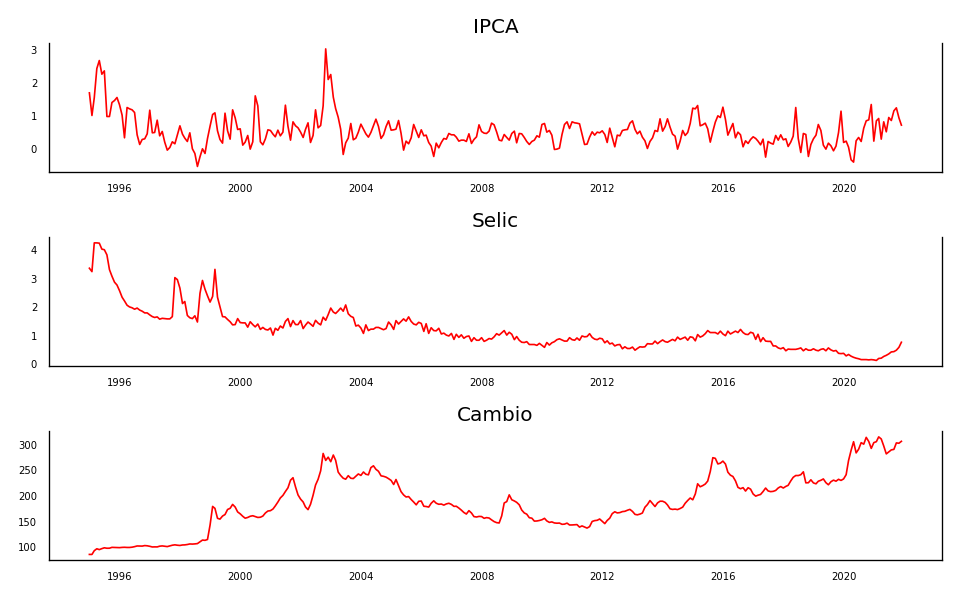

In [28]:
fig, axes = plt.subplots(nrows=3, ncols=1, dpi=120, figsize=(8,5))
for i, ax in enumerate(axes.flatten()):
    data = df2[df2.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    ax.set_title(df2.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)
    
plt.tight_layout();

### VAR

Como já visto acima, as séries da Selic e do Câmbio não são estacionárias em nível, impossibilitando a previsão com o modelo VAR. Nossa alternativa então foi tirar a 1ª diferença de tais séries para alcançar a condição de estacionariedade. Vamos agora separar nossos datasets auxiliares das primeiras diferenças em grupos de treinamento e de teste:

In [29]:
test_obs = 12
train1 = df_1ªdifference[:-test_obs]
test1 = df_1ªdifference[-test_obs:]

Verificando a Causalidade em nossas variáveis usando o Teste de Causalidade de Granger:

In [30]:
maxlag=12
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Função que verifica a causalidade de Granger de todas as combinações possíveis da série temporal.
    As linhas são a variável de resposta, as colunas são preditores. Os valores da tabela
    são os p-valores. P-valores menores que o nível de significância (0,05), implicam na rejeição da
    Hipótese Nula de que os coeficientes dos valores passados correspondentes são
    zero, ou seja, que X não causa Y.

    data      : Dataframe contendo as séries de interesse.
    variables : Lista contendo os nomes das variáveis.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P-Valores = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

In [31]:
grangers_causation_matrix(df_1ªdifference, variables = df2.columns)

,IPCA_x,Selic_x,Cambio_x
IPCA_y,1.0000,0.0058,0.0000
Selic_y,0.2486,1.0000,0.0499
Cambio_y,0.0022,0.0170,1.0000


Pela primeira linha da tabela é possível ver que nossos regressores Granger causam o IPCA, ou seja, temos forte evidência de que a Selic e o Câmbio apresentam uma relação de causalidade com nossa variável de interesse. 

Vamos agora para a especificação do modelo, aumentando iterativamente sua ordem de defasagem e verificando os valores dos critérios de informação.

In [32]:
model = VAR(df_1ªdifference)
for i in [1,2,3,4,5,6,7,8,9]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  -1.520408463976637
BIC :  -1.3797419467513796
FPE :  0.21862340752722983
HQIC:  -1.464249910018271 

Lag Order = 2
AIC :  -1.6500858043885078
BIC :  -1.4033560112865442
FPE :  0.1920374145566195
HQIC:  -1.551572670277026 

Lag Order = 3
AIC :  -1.6493386938596313
BIC :  -1.2960586005039652
FPE :  0.1921886911944376
HQIC:  -1.5082672470638792 

Lag Order = 4
AIC :  -1.6805047057155742
BIC :  -1.22018353640959
FPE :  0.18630517734302768
HQIC:  -1.496669635016051 

Lag Order = 5
AIC :  -1.671879559988755
BIC :  -1.104022747493634
FPE :  0.18794152051425891
HQIC:  -1.4450739587365975 

Lag Order = 6
AIC :  -1.6497386598319026
BIC :  -0.9738478045921393
FPE :  0.1921830279293749
HQIC:  -1.3797540089834253 

Lag Order = 7
AIC :  -1.7271915522117962
BIC :  -0.9427643810195929
FPE :  0.17790337969521977
HQIC:  -1.4138177031349688 

Lag Order = 8
AIC :  -1.756939032344861
BIC :  -0.8634693564339961
FPE :  0.17274557622075923
HQIC:  -1.3999641893940284 

Lag Order = 9
AIC : 

C:\Users\Gustavo\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


A tabela acima indica que o melhor nº de defasagem para especificação do modelo é 2.
Estimando então o modelo:

In [33]:
model = VAR(train1)
model_fitted = model.fit(2)
model_fitted.summary()

C:\Users\Gustavo\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 23, Mar, 2022
Time:                     10:13:47
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -1.40971
Nobs:                     309.000    HQIC:                  -1.56200
Log likelihood:          -1037.36    FPE:                   0.189492
AIC:                     -1.66343    Det(Omega_mle):        0.177176
--------------------------------------------------------------------
Results for equation IPCA
               coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------
const            -0.008718         0.018686           -0.467           0.641
L1.IPCA          -0.151283         0.055470           -2.727           0.006
L1.Selic         -0.036290         0.099414           -0.365           0.715


Preparando o modelo para previsão:

In [34]:
forecast_input = df_1ªdifference.values[-model_fitted.k_ar:]
forecast_input

array([[-0.3 ,  0.1 , -0.67],
       [-0.22,  0.18,  3.78]])

In [35]:
fc = model_fitted.forecast(y=forecast_input, steps=test_obs)
df_forecast = pd.DataFrame(fc, index=df2.index[-test_obs:], columns=df2.columns + '_2d')
df_forecast

,IPCA_2d,Selic_2d,Cambio_2d
Date,,,
2021-01-01,0.160004,-0.041025,1.073432
2021-02-01,0.074291,-0.006249,1.000351
2021-03-01,-0.057064,-0.008895,0.558663
2021-04-01,-0.013375,-0.016358,0.463971
2021-05-01,0.013100,-0.013803,0.657961
2021-06-01,-0.001640,-0.012099,0.680924
2021-07-01,-0.005615,-0.012990,0.633086
2021-08-01,-0.001336,-0.013273,0.634101
2021-09-01,-0.001100,-0.013012,0.644980


In [36]:
def invert_transformation(df_train, df_forecast, second_diff=False):
    """Função que reverte a diferenciação para obter a previsão na escala original."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_prev'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

In [37]:
df_results = invert_transformation(train1, df_forecast, second_diff=True)
df_results.loc[:, ['IPCA_prev', 'Selic_prev', 'Cambio_prev']]

,IPCA_prev,Selic_prev,Cambio_prev
Date,,,
2021-01-01,1.050004,-0.011025,-17.696568
2021-02-01,1.714298,-0.038298,-20.952784
2021-03-01,2.321529,-0.074467,-23.650338
2021-04-01,2.915384,-0.126994,-25.883920
2021-05-01,3.522339,-0.193325,-27.459542
2021-06-01,4.127655,-0.271754,-28.354239
2021-07-01,4.727356,-0.363173,-28.615850
2021-08-01,5.325720,-0.467865,-28.243361
2021-09-01,5.922984,-0.585569,-27.225892


Plotando os resultados da previsão junto aos valores reais:

<IPython.core.display.Javascript object>


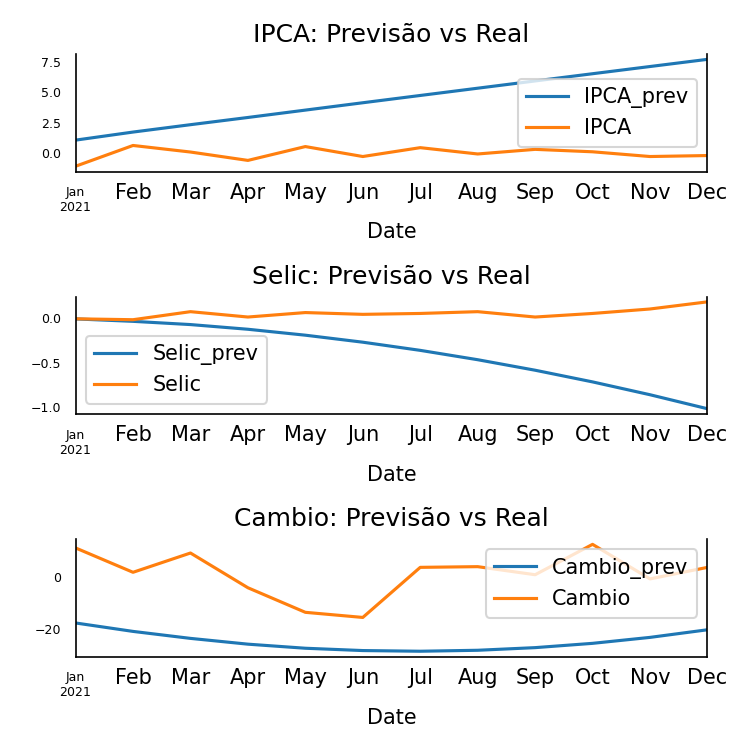

In [38]:
fig, axes = plt.subplots(nrows=3, ncols=1, dpi=150, figsize=(5,5))
for i, (col,ax) in enumerate(zip(df2.columns, axes.flatten())):
    df_results[col+'_prev'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    test1[col][-test_obs:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Previsão vs Real")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

Como visto acima, o modelo VAR também apresenta suas limitações relativas a acurácia da previsão.

Tratemos agora de um modelo mais completo, chamado modelo Vetor de Correção de Erros, ou VECM.

### VECM

O trunfo do VECM está no fato de ele corrigir um dos principais problemas do VAR. Resumidamente, se usamos um VAR com variáveis não estacionárias, mas com suas diferenças, podemos estar omitindo variáveis relevantes ao modelo.

Nosso 1º passo será realizar o Teste de Cointegração de Johansen, para verificar se nossas séries são cointegradas.
Vamos criar uma função para isto:

In [39]:
def cointegration_test(df, alpha=0.05): 
    """Função que realize o teste de cointegração de Johanson e devolve um resumo dele"""
    out = coint_johansen(df,0,2)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Resumo
    print('Nome   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

In [40]:
cointegration_test(df_1ªdifference)

Nome   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
IPCA   ::  322.77    > 29.7961   =>   True
Selic  ::  178.31    > 15.4943   =>   True
Cambio ::  68.08     > 3.8415    =>   True


A um nível de significancia de 5%, temos fortes evidências de que as 3 séries são cointegradas, indicando uma correlação de longo prazo entre elas.

O próximo passo diz respeito a identificação do modelo, onde precisamos realizar o teste de verificação do rank de nossas séries.

In [41]:
rank_test = select_coint_rank(df_1ªdifference, 0, 2, method="trace",
                              signif=0.05)
rank_test.rank

3

In [42]:
rank_test.summary()

r_0,r_1,test statistic,critical value
0,3,322.8,29.80
1,3,178.3,15.49
2,3,68.08,3.841


In [43]:
print(rank_test)

Johansen cointegration test using trace test statistic with 5% significance level
r_0 r_1 test statistic critical value
-------------------------------------
  0   3          322.8          29.80
  1   3          178.3          15.49
  2   3          68.08          3.841
-------------------------------------


O valor do rank então é 3.
Assim, estamos aptos a estimar o modelo:

In [44]:
model_vecm = VECM(df_1ªdifference, deterministic="ci", seasons=4,
             k_ar_diff=model_fitted.k_ar,  # =3
             coint_rank=rank_test.rank)

C:\Users\Gustavo\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


In [45]:
vecm_result = model_vecm.fit()

In [46]:
vecm_result.summary()

,coef,std err,z,P>|z|,[0.025,0.975]
season1,0.0167,0.053,0.316,0.752,-0.087,0.121
season2,0.0532,0.052,1.029,0.303,-0.048,0.155
season3,0.0082,0.053,0.156,0.876,-0.095,0.112
L1.IPCA,0.2907,0.084,3.460,0.001,0.126,0.455
L1.Selic,-0.0752,0.152,-0.496,0.620,-0.372,0.222
L1.Cambio,-0.0011,0.003,-0.361,0.718,-0.007,0.005
L2.IPCA,0.0420,0.054,0.784,0.433,-0.063,0.147
L2.Selic,0.1057,0.102,1.036,0.300,-0.094,0.306
L2.Cambio,-0.0004,0.003,-0.155,0.877,-0.005,0.005
,coef,std err,z,P>|z|,[0.025,0.975]


In [47]:
vecm_result.alpha

array([[-1.49527262e+00, -2.85529621e-02,  1.24500876e-02],
       [ 7.47684698e-02, -1.11744788e+00,  6.47132673e-04],
       [ 4.56030409e+00, -5.98767244e+00, -7.10589009e-01]])

In [48]:
vecm_result.stderr_alpha

array([[1.13614643e-01, 1.91581575e-01, 3.53823561e-03],
       [6.03194644e-02, 1.01713104e-01, 1.87849446e-03],
       [2.51642676e+00, 4.24329989e+00, 7.83676341e-02]])

In [49]:
vecm_result.predict(steps=5)

array([[ 0.12342802, -0.06956117,  1.71014669],
       [ 0.07595759, -0.04047522,  0.06148432],
       [-0.04164792,  0.04881397, -0.5855105 ],
       [-0.05216153, -0.03370852,  0.62405214],
       [ 0.0072024 , -0.01786277,  1.52978458]])

In [50]:
vecm_result.predict(steps=5, alpha=0.05)
for text, vaĺues in zip(("forecast", "lower", "upper"), vecm_result.predict(steps=5, alpha=0.05)):
    print(text+":", vaĺues, sep="\n")

forecast:
[[ 0.12342802 -0.06956117  1.71014669]
 [ 0.07595759 -0.04047522  0.06148432]
 [-0.04164792  0.04881397 -0.5855105 ]
 [-0.05216153 -0.03370852  0.62405214]
 [ 0.0072024  -0.01786277  1.52978458]]
lower:
[[ -0.50666784  -0.40408711 -12.24571338]
 [ -0.58870142  -0.38010271 -14.83261259]
 [ -0.71981841  -0.29111443 -15.50921309]
 [ -0.73370067  -0.37441781 -14.41679649]
 [ -0.67608534  -0.35860549 -13.53500331]]
upper:
[[ 0.75352387  0.26496476 15.66600676]
 [ 0.7406166   0.29915228 14.95558124]
 [ 0.63652257  0.38874236 14.33819209]
 [ 0.6293776   0.30700077 15.66490077]
 [ 0.69049014  0.32287994 16.59457248]]


Por fim, podemos plotar os resultados da estimação, como se segue abaixo:

<IPython.core.display.Javascript object>


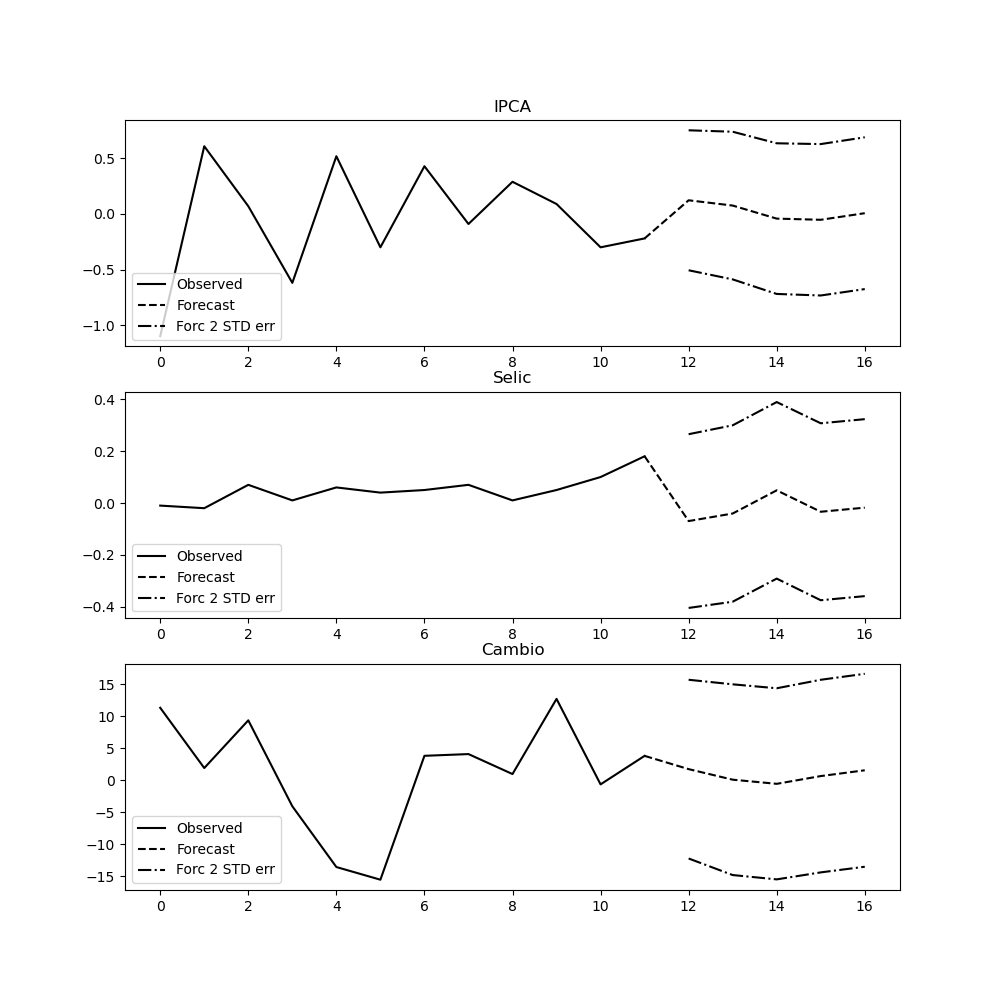

In [51]:
vecm_plot = vecm_result.plot_forecast(steps=5, n_last_obs=12)

## Previsão/Estimação usando Deep Learning

Conforme dito no início, para este modelo usando Deep Learning, precisamos que nosso dataset seja convertido para array. Além disso, aqui estaremos trabalhando com nosso dataset principal completo, ou seja, com a série do IPCA mais 16 outras variáveis que podem ter um poder de influência sobre ela.

In [52]:
df3

array([[ 1.70000000e+00,  9.20000000e-01,  1.63000000e+00, ...,
         1.11000000e+00, -8.73700000e+02,  6.52746400e+04],
       [ 1.02000000e+00,  1.39000000e+00,  1.97000000e+00, ...,
         8.70000000e-01, -1.52720000e+03,  6.83076700e+04],
       [ 1.55000000e+00,  1.12000000e+00,  2.74000000e+00, ...,
         1.02000000e+00, -1.61460000e+03,  7.12966200e+04],
       ...,
       [ 1.25000000e+00,  6.40000000e-01,  7.70000000e-01, ...,
         2.72000000e+00, -7.64000000e+01,  3.93855303e+06],
       [ 9.50000000e-01,  2.00000000e-02,  1.08000000e+00, ...,
        -9.30000000e-01, -3.92150000e+03,  3.98657980e+06],
       [ 7.30000000e-01,  8.70000000e-01,  5.70000000e-01, ...,
         1.54000000e+00,  8.21700000e+02,  4.02971309e+06]])

In [53]:
df_train

array([[ 1.70000000e+00,  9.20000000e-01,  1.63000000e+00, ...,
         1.11000000e+00, -8.73700000e+02,  6.52746400e+04],
       [ 1.02000000e+00,  1.39000000e+00,  1.97000000e+00, ...,
         8.70000000e-01, -1.52720000e+03,  6.83076700e+04],
       [ 1.55000000e+00,  1.12000000e+00,  2.74000000e+00, ...,
         1.02000000e+00, -1.61460000e+03,  7.12966200e+04],
       ...,
       [ 7.80000000e-01,  8.20000000e-01,  6.40000000e-01, ...,
         7.10000000e-01,  3.62080000e+03,  1.58857055e+06],
       [ 3.50000000e-01,  1.69000000e+00,  2.60000000e-01, ...,
         7.10000000e-01,  2.83000000e+01,  1.74654189e+06],
       [ 5.20000000e-01,  1.80000000e-01,  3.70000000e-01, ...,
        -3.00000000e-01,  1.92930000e+03,  1.82004130e+06]])

In [54]:
df_test

array([[ 8.00000000e-02,  2.00000000e-01,  7.00000000e-02, ...,
         6.00000000e-01,  9.12500000e+02,  1.89774965e+06],
       [ 2.60000000e-01,  1.60000000e-01,  3.40000000e-01, ...,
         2.20000000e-01, -7.49700000e+02,  1.91893631e+06],
       [ 1.80000000e-01, -3.00000000e-02,  1.70000000e-01, ...,
         7.50000000e-01,  2.07300000e+03,  1.92882775e+06],
       ...,
       [ 1.25000000e+00,  6.40000000e-01,  7.70000000e-01, ...,
         2.72000000e+00, -7.64000000e+01,  3.93855303e+06],
       [ 9.50000000e-01,  2.00000000e-02,  1.08000000e+00, ...,
        -9.30000000e-01, -3.92150000e+03,  3.98657980e+06],
       [ 7.30000000e-01,  8.70000000e-01,  5.70000000e-01, ...,
         1.54000000e+00,  8.21700000e+02,  4.02971309e+06]])

### Escalonamento dos dados

Nosso modelo de Dl fará uso de técnicas de redes neurais. Desta maneira, como quase todas as redes neurais se beneficiam do reescalonamento dos inputs (e algumas vezes dos outputs), e como nossos dados não estão na mesma escala, vamos utilizar a função 'MinMaxScaler' do pacote de mesmo nome para reestrutura-los numa escala de -1 a 1. 

In [55]:
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler.fit(df_train)

MinMaxScaler(feature_range=(-1, 1))

In [56]:
scaler

MinMaxScaler(feature_range=(-1, 1))

In [57]:
df_train = scaler.transform(df_train)
df_test = scaler.transform(df_test)

In [58]:
df_train

array([[ 0.25212465, -0.37964459, -0.12423625, ..., -0.43825666,
         0.11666963, -1.        ],
       [-0.13314448, -0.22778675,  0.01425662, ..., -0.49636804,
         0.01093727, -0.9965431 ],
       [ 0.16713881, -0.31502423,  0.32790224, ..., -0.46004843,
        -0.00320352, -0.99313643],
       ...,
       [-0.26912181, -0.41195477, -0.52749491, ..., -0.53510896,
         0.84385264,  0.73618059],
       [-0.51274788, -0.13085622, -0.68228106, ..., -0.53510896,
         0.2626078 ,  0.91622885],
       [-0.41643059, -0.6187399 , -0.63747454, ..., -0.77966102,
         0.57017814,  1.        ]])

Depois disso, precisaremos separar os inputs dos outputs.

In [59]:
x_train = df_train[:, 1:]
y_train = df_train[:, 0]
x_test = df_test[:, 1:]
y_test = df_test[:, 0]

In [60]:
x_train

array([[-0.37964459, -0.12423625, -0.13700108, ..., -0.43825666,
         0.11666963, -1.        ],
       [-0.22778675,  0.01425662, -0.4412082 , ..., -0.49636804,
         0.01093727, -0.9965431 ],
       [-0.31502423,  0.32790224, -0.18015102, ..., -0.46004843,
        -0.00320352, -0.99313643],
       ...,
       [-0.41195477, -0.52749491, -0.87486516, ..., -0.53510896,
         0.84385264,  0.73618059],
       [-0.13085622, -0.68228106, -0.47572816, ..., -0.53510896,
         0.2626078 ,  0.91622885],
       [-0.6187399 , -0.63747454, -0.78640777, ..., -0.77966102,
         0.57017814,  1.        ]])

In [61]:
y_train

array([ 0.25212465, -0.13314448,  0.16713881,  0.66572238,  0.80169972,
        0.5694051 ,  0.62606232, -0.15014164, -0.15014164,  0.0878187 ,
        0.12181303,  0.17280453,  0.04815864, -0.12747875, -0.51274788,
        0.00283286, -0.01983003, -0.0368272 , -0.08215297, -0.46175637,
       -0.62606232, -0.54107649, -0.52974504, -0.44475921, -0.04249292,
       -0.42776204, -0.42209632, -0.21246459, -0.47875354, -0.40509915,
       -0.58640227, -0.7223796 , -0.67705382, -0.58073654, -0.61473088,
       -0.4674221 , -0.30878187, -0.45042493, -0.5184136 , -0.57507082,
       -0.42776204, -0.69971671, -0.77903683, -1.        , -0.83569405,
       -0.69971671, -0.77903683, -0.52407932, -0.31444759, -0.11614731,
       -0.0878187 , -0.39376771, -0.54107649, -0.60339943, -0.09348442,
       -0.39376771, -0.53541076, -0.0368272 , -0.17280453, -0.37110482,
       -0.35977337, -0.63739377, -0.58640227, -0.47308782, -0.70538244,
       -0.58073654,  0.20113314,  0.03116147, -0.58073654, -0.63

In [62]:
x_test

array([[-0.61227787, -0.75967413, -0.82092772, ..., -0.56174334,
         0.40566602,  1.0885683 ],
       [-0.62520194, -0.6496945 , -0.84681769, ..., -0.65375303,
         0.13673209,  1.11271585],
       [-0.68659128, -0.71894094, -0.85760518, ..., -0.52542373,
         0.59342793,  1.12398965],
       ...,
       [-0.47011309, -0.47454175, -0.70658037, ..., -0.04842615,
         0.24566797,  3.41457942],
       [-0.67043619, -0.34826884, -0.74757282, ..., -0.93220339,
        -0.37644603,  3.46931806],
       [-0.39579968, -0.55600815, -0.81661273, ..., -0.33414044,
         0.39097513,  3.51847934]])

In [63]:
y_test

array([-0.66572238, -0.56373938, -0.60906516, -0.54107649, -0.49575071,
       -0.52407932, -0.5694051 , -0.63172805, -0.53541076, -0.84135977,
       -0.57507082, -0.60339943, -0.6203966 , -0.47308782, -0.55240793,
       -0.46175637, -0.54674221, -0.52974504, -0.66005666, -0.58640227,
       -0.48441926,  0.00283286, -0.52407932, -0.76203966, -0.43909348,
       -0.45609065, -0.83002833, -0.62606232, -0.52974504, -0.4674221 ,
       -0.28611898, -0.38810198, -0.63739377, -0.70538244, -0.60339943,
       -0.64872521, -0.73371105, -0.65439093, -0.42209632, -0.05949008,
       -0.59206799, -0.5694051 , -0.6713881 , -0.88668555, -0.92634561,
       -0.56373938, -0.50708215, -0.57507082, -0.34844193, -0.22379603,
       -0.20679887,  0.05382436, -0.5694051 , -0.22379603, -0.18413598,
       -0.53541076, -0.2407932 , -0.41076487, -0.16713881, -0.21813031,
       -0.05382436, -0.00283286, -0.17280453, -0.29745042])

### Construção do modelo

Vamos separar em um objeto o nº de variáveis em nossa base de treinamento.

In [64]:
n_vars = x_train.shape[1]
print(n_vars)

16


Um ponto importante a se notar é que iremos construir a rede neural sem utilizarmos o Keras. Inicialmente precisamos definir uma sessão:

In [65]:
net = tf.compat.v1.InteractiveSession()

In [66]:
net

Precisamos então construir as camadas com os neurônios e definir como os dados entrarão nelas.
Para isso, precisamos primeiro criar nossos placeholders, que serão usados para armazenar os dados dos inputs e do output. Serão dois placeholders, X e Y, com X contendo os inputs da nossa rede (as variáveis que podem ter um poder de explicação sobre o IPCA, em T = t) e Y contendo o output (o IPCA em T = t+1).
O shape dos placeholders corresponde a [None, n_vars], onde "None" significa que os inputs vem em uma matriz bi-dimensional e o output de um vetor uni-dimensional.

In [67]:
tf.compat.v1.disable_eager_execution()

X = tf.compat.v1.placeholder(dtype=tf.float32, shape=[None, n_vars])
Y = tf.compat.v1.placeholder(dtype=tf.float32, shape=[None])

In [68]:
X

<tf.Tensor 'Placeholder:0' shape=(None, 16) dtype=float32>

In [69]:
Y

<tf.Tensor 'Placeholder_1:0' shape=(None,) dtype=float32>

#### Neurônios:
O modelo irá possuir quatro camadas (hidden layers), além da camada de entrada e da camada de saída. A primeira camada vai conter 32, e as camadas seguintes possuirão como tamanho a metade das camadas anteriores, sendo 16, 8 e 4, respectivamente. A redução no número de neurônios vai comprimindo a informação identificada em cada camada anterior. 

In [70]:
n_neurons_1 = 32
n_neurons_2 = 16
n_neurons_3 = 8
n_neurons_4 = 4

#### Inicializadores:
Inicializadores são utilizados para inicializar as variáveis da rede antes do treinamento. Como as redes neurais são treinadas utilizando técnicas de otimização numérica, a condição inicial do problema de otimização é crucial para se obter boas soluções para o problema. O TensorFlow possui diferentes inicializadores, mas aqui usaremos 2, sendo eles:

**variance_scaling_initializer:** Constrói um inicializador que gera tensores sem reescalonar a variância. É sempre bom se pudermos manter a escala da variância dos inputs constante ao inicializarmos uma rede de forma que não exploda nem diminua ao chegarmos na camada final de nossa rede. 
Quando utilizamos uma distribuição normal as amostras serão obtidas da distribuição com média zero e variância,

\begin{equation}
    stddev = sqrt(scale / n)
\end{equation}

e com os seguintes parâmetros:
        
        * n:
            - Será o número de conexões no tensor de input, se mode = "fan_in";
            - Será o número de conexões no tensor de output, se mode = "fan_out";
            - Será a média de conexões no tensor de input e output, se mode = "fan_avg";
            
        * distribution: Distribuição aleatória a ser utilizada ("normal", "uniforme", etc);
        
        * scale: Fator de escalonamento (float positiva).

Será usado como inicializador dos pesos.

**zeros_initializer:** Inicializador que gera tensores inicializados em 0. Será usado como inicializador do viés.

In [71]:
sigma = 1
weight_initializer = tf.compat.v1.variance_scaling_initializer(mode="fan_avg", distribution="uniform", scale=sigma)
bias_initializer = tf.compat.v1.zeros_initializer()

In [72]:
weight_initializer

In [73]:
bias_initializer

#### Variáveis:

In [74]:
# Camada 1: Variáveis para pesos e viés
W_hidden_1 = tf.compat.v1.Variable(weight_initializer([n_vars, n_neurons_1]))
bias_hidden_1 = tf.compat.v1.Variable(bias_initializer([n_neurons_1]))

# Camada 2: Variáveis para pesos e viés
W_hidden_2 = tf.compat.v1.Variable(weight_initializer([n_neurons_1, n_neurons_2]))
bias_hidden_2 = tf.compat.v1.Variable(bias_initializer([n_neurons_2]))

# Camada 3: Variáveis para pesos e viés
W_hidden_3 = tf.compat.v1.Variable(weight_initializer([n_neurons_2, n_neurons_3]))
bias_hidden_3 = tf.compat.v1.Variable(bias_initializer([n_neurons_3]))

# Camada 4: Variáveis para pesos e viés
W_hidden_4 = tf.compat.v1.Variable(weight_initializer([n_neurons_3, n_neurons_4]))
bias_hidden_4 = tf.compat.v1.Variable(bias_initializer([n_neurons_4]))

# Output weights
# Camada de Output: Variáveis para pesos e viés do output
W_out = tf.compat.v1.Variable(weight_initializer([n_neurons_4, 1]))
bias_out = tf.compat.v1.Variable(bias_initializer([1]))

### Desenhando a Arquitetura da Rede Neural

Os placeholders (dados) e as variáveis (pesos e viés) precisam ser combinados em um sistema de multiplicação matricial sequencial.
Também, as camadas de nossa rede serão transformadas por funções de ativação. Funções de ativação são elementos importantes de redes neurais uma vez que introduzem não linearidade ao sistema. Existem dezenas de funções de ativação, uma das mais comuns é a rectified linear unit (ReLU), que usaremos aqui nesta rede.
Do tensorflow, usaremos ainda as seguintes funcionalidades:
    
    * tf.nn: Encapsulador para operações com redes neurais primitivas (NN);
    * tf.matmul: Multiplica a matriz A pela matriz B, produzindo A * B.

In [75]:
hidden_1 = tf.compat.v1.nn.relu(tf.compat.v1.add(tf.compat.v1.matmul(X, W_hidden_1), bias_hidden_1))
hidden_2 = tf.compat.v1.nn.relu(tf.compat.v1.add(tf.compat.v1.matmul(hidden_1, W_hidden_2), bias_hidden_2))
hidden_3 = tf.compat.v1.nn.relu(tf.compat.v1.add(tf.compat.v1.matmul(hidden_2, W_hidden_3), bias_hidden_3))
hidden_4 = tf.compat.v1.nn.relu(tf.compat.v1.add(tf.compat.v1.matmul(hidden_3, W_hidden_4), bias_hidden_4))

#### Camada de output (transposta):

In [76]:
out = tf.compat.v1.transpose(tf.add(tf.matmul(hidden_4, W_out), bias_out))

In [77]:
out

<tf.Tensor 'transpose:0' shape=(1, None) dtype=float32>

#### Função Custo (Perda): 
A função custo ou função perda é utilizada para gerar uma medida de desvio entre a previsão da rede e o valor real observado no treinamento. Para problemas de regressão o erro quadrado médio (MSE) é bastante utilizado.

In [78]:
mse = tf.compat.v1.reduce_mean(tf.compat.v1.squared_difference(out, Y))

In [79]:
mse

<tf.Tensor 'Mean:0' shape=() dtype=float32>

#### Otimizador:
O otimizador se encarrega dos cálculos necessários para adaptar os pesos e viés da rede durante o treinamento. Esses cálculos utilizam gradientes que indicam a direção em que os pesos e viés devem ser modificados de forma a minimizar a função custo. O desenvolvimento de otimizadores estáveis e rápidos é uma area em que há grande pesquisa atualmente.
Utilizaremos aqui o otimizador ADAM (Adaptive Moment Estimation).

In [80]:
opt = tf.compat.v1.train.AdamOptimizer().minimize(mse)

In [81]:
opt

<tf.Operation 'Adam' type=NoOp>

#### Treinamento:
Após definirmos placeholders, variáveis, inicializadores, custo e otimizadores, o modelo precisa ser treinado.

In [82]:
net.run(tf.compat.v1.global_variables_initializer())

Em paralelo a isso, criaremos um gráfico interativo com nossas linhas de teste (azul) e de treinamento (laranja), deslocando esta última 1/2 de modo a visualizar seu movimento em direção ao nível do valor real.

#### Rodar o modelo:
Durante o treinamento do modelo amostras aleatórias de tamanho  𝑛=  batch_size serão retiradas da base de treinamento. Este procedimento continua até todos os batches serem apresentados a rede. Uma apresentação completa de todos os batches a rede é chamada de uma época.

In [83]:
epochs = 50
batch_size = 1
mse_train = []
mse_test = []

Como nosso nº de observações é relativamente baixo, utilizaremos uma grande quantidade de épocas (50) e o valor mínimo para o batch_size (1).

In [84]:
np.mean(y_test)

-0.483356940509915

<IPython.core.display.Javascript object>


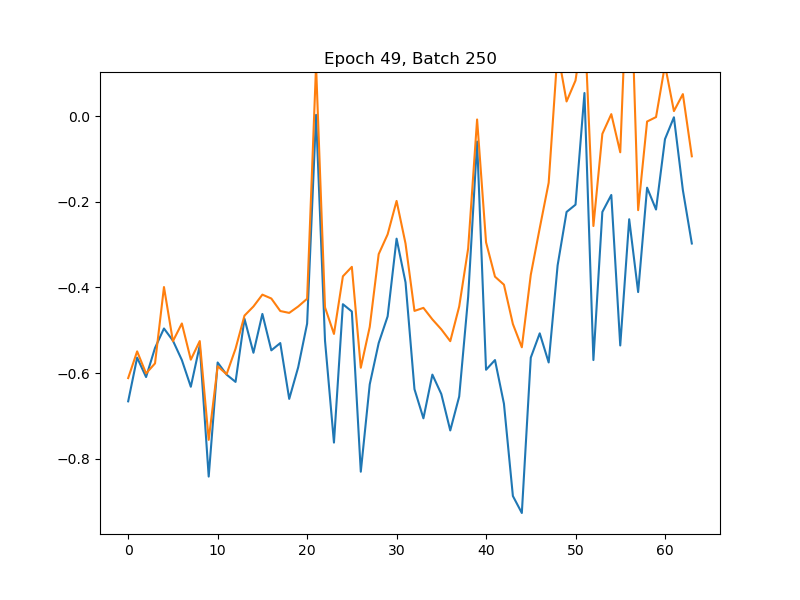

In [85]:
plt.ion()
fig = plt.figure(figsize=(8,6))
ax1 = fig.add_subplot(111)
line1, = ax1.plot(y_test)
line2, = ax1.plot(y_test * 0.5)
fig = plt.gcf()
plt.show()

In [86]:
for e in range(epochs):
    # Shuffle training data
    shuffle_indices = np.random.permutation(np.arange(len(y_train)))
    x_train = x_train[shuffle_indices]
    y_train = y_train[shuffle_indices]
    # Minibatch training
    for i in range(0, len(y_train) // batch_size):
        start = i * batch_size
        batch_x = x_train[start:start + batch_size]
        batch_y = y_train[start:start + batch_size]
        # Run optimizer with batch
        net.run(opt, feed_dict={X: batch_x, Y: batch_y})
        # Show progress
        if np.mod(i, 10) == 0: # Return element-wise remainder of division
            # MSE train and test
            mse_train.append(net.run(mse, feed_dict={X: x_train, Y: y_train}))
            mse_test.append(net.run(mse, feed_dict={X: x_test, Y: y_test}))
            print('MSE Train: ', mse_train[-1])
            print('MSE Test: ', mse_test[-1])
            # Prediction
            pred = net.run(out, feed_dict={X: x_test})
            line2.set_ydata(pred)
            plt.title('Epoch ' + str(e) + ', Batch ' + str(i))
            fig.canvas.draw()
            plt.pause(0.05)

MSE Train:  0.34059113
MSE Test:  0.33347648
MSE Train:  0.22497955
MSE Test:  0.3081661
MSE Train:  0.2038158
MSE Test:  0.29295135
MSE Train:  0.19605932
MSE Test:  0.27996373
MSE Train:  0.18867807
MSE Test:  0.26640147
MSE Train:  0.18179235
MSE Test:  0.25505137
MSE Train:  0.17586201
MSE Test:  0.24577394
MSE Train:  0.17067653
MSE Test:  0.2384711
MSE Train:  0.16582666
MSE Test:  0.23143102
MSE Train:  0.16118273
MSE Test:  0.22382343
MSE Train:  0.15708281
MSE Test:  0.21657604
MSE Train:  0.15360764
MSE Test:  0.21120852
MSE Train:  0.14969774
MSE Test:  0.20571701
MSE Train:  0.14588185
MSE Test:  0.20035262
MSE Train:  0.14161567
MSE Test:  0.19437836
MSE Train:  0.13833328
MSE Test:  0.18953347
MSE Train:  0.13447174
MSE Test:  0.18509424
MSE Train:  0.13011959
MSE Test:  0.1799267
MSE Train:  0.12605149
MSE Test:  0.17463097
MSE Train:  0.12227427
MSE Test:  0.16951813
MSE Train:  0.11883722
MSE Test:  0.16475737
MSE Train:  0.115162745
MSE Test:  0.15946299
MSE Train:  0

MSE Train:  0.012278879
MSE Test:  0.029280711
MSE Train:  0.012789981
MSE Test:  0.030253086
MSE Train:  0.01164733
MSE Test:  0.028244432
MSE Train:  0.011659117
MSE Test:  0.027782746
MSE Train:  0.0110004395
MSE Test:  0.02684247
MSE Train:  0.012114614
MSE Test:  0.03545821
MSE Train:  0.012495826
MSE Test:  0.02556805
MSE Train:  0.012333687
MSE Test:  0.024846865
MSE Train:  0.013651801
MSE Test:  0.027535323
MSE Train:  0.0106597785
MSE Test:  0.027058665
MSE Train:  0.010722198
MSE Test:  0.024229849
MSE Train:  0.010946489
MSE Test:  0.026889622
MSE Train:  0.010475679
MSE Test:  0.023196852
MSE Train:  0.01038554
MSE Test:  0.022860479
MSE Train:  0.0116805155
MSE Test:  0.04010798
MSE Train:  0.01082563
MSE Test:  0.026851362
MSE Train:  0.011297041
MSE Test:  0.02978035
MSE Train:  0.012501943
MSE Test:  0.09105996
MSE Train:  0.01585058
MSE Test:  0.14812067
MSE Train:  0.016785009
MSE Test:  0.157909
MSE Train:  0.015374261
MSE Test:  0.14434847
MSE Train:  0.010480368
M

MSE Train:  0.006158211
MSE Test:  0.06163757
MSE Train:  0.0054641427
MSE Test:  0.07171062
MSE Train:  0.0056397226
MSE Test:  0.0635912
MSE Train:  0.0053971466
MSE Test:  0.08074634
MSE Train:  0.005058614
MSE Test:  0.108824626
MSE Train:  0.0053112535
MSE Test:  0.07777873
MSE Train:  0.006606948
MSE Test:  0.103654325
MSE Train:  0.0053729387
MSE Test:  0.08318185
MSE Train:  0.0072504324
MSE Test:  0.12209441
MSE Train:  0.009317006
MSE Test:  0.1567861
MSE Train:  0.009886303
MSE Test:  0.2085352
MSE Train:  0.008297318
MSE Test:  0.19366318
MSE Train:  0.006481052
MSE Test:  0.10462923
MSE Train:  0.004919215
MSE Test:  0.09963926
MSE Train:  0.006082402
MSE Test:  0.056666076
MSE Train:  0.0074317544
MSE Test:  0.028914003
MSE Train:  0.0048154285
MSE Test:  0.06620781
MSE Train:  0.0053099557
MSE Test:  0.10652621
MSE Train:  0.006226882
MSE Test:  0.13457124
MSE Train:  0.006481073
MSE Test:  0.065547876
MSE Train:  0.0067508793
MSE Test:  0.05113843
MSE Train:  0.00572644

MSE Train:  0.0056595597
MSE Test:  0.12022172
MSE Train:  0.0053854943
MSE Test:  0.07004284
MSE Train:  0.0051804106
MSE Test:  0.036387067
MSE Train:  0.0040889345
MSE Test:  0.04077673
MSE Train:  0.004487124
MSE Test:  0.060469434
MSE Train:  0.003951455
MSE Test:  0.03772302
MSE Train:  0.0037943309
MSE Test:  0.044896103
MSE Train:  0.004061145
MSE Test:  0.03243339
MSE Train:  0.0049959
MSE Test:  0.03710916
MSE Train:  0.0045004645
MSE Test:  0.04507905
MSE Train:  0.0035245414
MSE Test:  0.051865168
MSE Train:  0.0038093445
MSE Test:  0.06572235
MSE Train:  0.003661676
MSE Test:  0.03790679
MSE Train:  0.0039448207
MSE Test:  0.032469265
MSE Train:  0.003776393
MSE Test:  0.039736703
MSE Train:  0.0041544084
MSE Test:  0.039956868
MSE Train:  0.0048005995
MSE Test:  0.05619618
MSE Train:  0.0039096423
MSE Test:  0.037421614
MSE Train:  0.0054927627
MSE Test:  0.020665387
MSE Train:  0.007477166
MSE Test:  0.017436337
MSE Train:  0.0039663957
MSE Test:  0.027986558
MSE Train: 

MSE Test:  0.081834346
MSE Train:  0.0038860065
MSE Test:  0.089584105
MSE Train:  0.00409973
MSE Test:  0.09133714
MSE Train:  0.0028898346
MSE Test:  0.06150759
MSE Train:  0.0032973355
MSE Test:  0.07022442
MSE Train:  0.0042225625
MSE Test:  0.06400341
MSE Train:  0.0050101643
MSE Test:  0.05468987
MSE Train:  0.0036043716
MSE Test:  0.050540715
MSE Train:  0.0041360077
MSE Test:  0.053099506
MSE Train:  0.004131924
MSE Test:  0.09995728
MSE Train:  0.0034310932
MSE Test:  0.11187196
MSE Train:  0.005162798
MSE Test:  0.12334436
MSE Train:  0.00364793
MSE Test:  0.084883206
MSE Train:  0.0055522774
MSE Test:  0.06813769
MSE Train:  0.0036720892
MSE Test:  0.11302768
MSE Train:  0.0052367146
MSE Test:  0.12841748
MSE Train:  0.00395807
MSE Test:  0.08075599
MSE Train:  0.0034084236
MSE Test:  0.09495853
MSE Train:  0.0033156888
MSE Test:  0.10151996
MSE Train:  0.003449992
MSE Test:  0.0993133
MSE Train:  0.0033363625
MSE Test:  0.08451624
MSE Train:  0.0042400975
MSE Test:  0.09421

MSE Train:  0.0030445314
MSE Test:  0.038458154
MSE Train:  0.0039785905
MSE Test:  0.031672854
MSE Train:  0.0033500271
MSE Test:  0.07002266
MSE Train:  0.0026758797
MSE Test:  0.062842995
MSE Train:  0.0026851217
MSE Test:  0.06162134
MSE Train:  0.0025953145
MSE Test:  0.0836968
MSE Train:  0.0030781047
MSE Test:  0.0705968
MSE Train:  0.0024996821
MSE Test:  0.060947403
MSE Train:  0.002641626
MSE Test:  0.06163668
MSE Train:  0.003009747
MSE Test:  0.057907164
MSE Train:  0.002958751
MSE Test:  0.057242107
MSE Train:  0.0029066985
MSE Test:  0.056553625
MSE Train:  0.0037084934
MSE Test:  0.059835397
MSE Train:  0.0026301206
MSE Test:  0.048341997
MSE Train:  0.0029315667
MSE Test:  0.06109312
MSE Train:  0.0033767365
MSE Test:  0.07837369
MSE Train:  0.0033499063
MSE Test:  0.0837813
MSE Train:  0.0031349128
MSE Test:  0.053519152
MSE Train:  0.0028251596
MSE Test:  0.0525715
MSE Train:  0.0037252607
MSE Test:  0.04932833
MSE Train:  0.0038143173
MSE Test:  0.061116144
MSE Train

MSE Train:  0.0027195641
MSE Test:  0.08512076
MSE Train:  0.0028718312
MSE Test:  0.053816974
MSE Train:  0.0034393633
MSE Test:  0.060184427
MSE Train:  0.0056651044
MSE Test:  0.07513927
MSE Train:  0.003139527
MSE Test:  0.05942134
MSE Train:  0.0039025827
MSE Test:  0.08052869
MSE Train:  0.0046107676
MSE Test:  0.103174485
MSE Train:  0.0025911746
MSE Test:  0.08182104
MSE Train:  0.0027442614
MSE Test:  0.052251756
MSE Train:  0.002862254
MSE Test:  0.056311145
MSE Train:  0.0033012847
MSE Test:  0.07817342
MSE Train:  0.0026867492
MSE Test:  0.057623878
MSE Train:  0.0042889346
MSE Test:  0.045826994
MSE Train:  0.0033149894
MSE Test:  0.04559326
MSE Train:  0.0029156369
MSE Test:  0.038434334
MSE Train:  0.006230788
MSE Test:  0.11500211
MSE Train:  0.0029356626
MSE Test:  0.08006737
MSE Train:  0.002829488
MSE Test:  0.07210548
MSE Train:  0.002311512
MSE Test:  0.063058265
MSE Train:  0.002574128
MSE Test:  0.06095542
MSE Train:  0.0024771942
MSE Test:  0.050925575
MSE Train

MSE Train:  0.0023770537
MSE Test:  0.07987205
MSE Train:  0.0025397805
MSE Test:  0.06865326
MSE Train:  0.0026945295
MSE Test:  0.052056894
MSE Train:  0.002057027
MSE Test:  0.05718756
MSE Train:  0.0023885516
MSE Test:  0.05953397
MSE Train:  0.0025322349
MSE Test:  0.03934285
MSE Train:  0.0025473563
MSE Test:  0.031517148
MSE Train:  0.0026677528
MSE Test:  0.022396624
MSE Train:  0.0025875557
MSE Test:  0.023514418
MSE Train:  0.0022894577
MSE Test:  0.024581011
MSE Train:  0.00248372
MSE Test:  0.02058784
MSE Train:  0.0034091263
MSE Test:  0.025026644
MSE Train:  0.0032826439
MSE Test:  0.04104993
MSE Train:  0.0030462684
MSE Test:  0.027322352
MSE Train:  0.0026158746
MSE Test:  0.019437065
MSE Train:  0.00335824
MSE Test:  0.02129811
MSE Train:  0.0023518591
MSE Test:  0.028788432
MSE Train:  0.0027643917
MSE Test:  0.04798612
MSE Train:  0.0027437194
MSE Test:  0.026978267
MSE Train:  0.00290333
MSE Test:  0.024845663
MSE Train:  0.002227003
MSE Test:  0.02970462
MSE Train:

Podemos ver no gráfico acima que o modelo de Dl é o que melhor se ajusta aos valores reais, tendo a maior acurácia entre todos mostrados até aqui.

## Referências

* BUENO, Rodrigo De Losso da Silveira. Econometria de séries temporais. [S.l: s.n.], 2012.

* Pacheco, C. A. R., & Pereira, N. S. (2018). Deep Learning Conceitos e Utilização nas Diversas Áreas do Conhecimento. Revista Ada Lovelace, 2, 34–49. Recuperado de http://anais.unievangelica.edu.br/index.php/adalovelace/article/view/4132